IMPORTING REQUIRED LIBRARIES
First, I import all the required libraries only once to ensure reproducibility and avoid redundancy.
These libraries cover:
file handling
visualization
deep learning
evaluation metrics

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report


DATASET ORGANIZATION AND SPLITTING
My dataset contains six plastic classes:
Others, PC, PE, PET, PP, PS.
Each folder represents a class.

To ensure unbiased evaluation, I split the dataset into:
70% training
15% validation
15% testing

DataSet Link: https://www.kaggle.com/datasets/harshitkandoi7850/dataset-for-visual-plastic-type-recognition

In [2]:
source_dir = r"E:\11th semester\01066 COMPUTER VISION AND PATTERN RECOGNITION [A][FALL 25-26]\FINAL\Plastic types"
target_dir = r"E:\Plastic_Dataset"

train_ratio, val_ratio = 0.7, 0.15
classes = os.listdir(source_dir)

for cls in classes:
    images = os.listdir(os.path.join(source_dir, cls))
    random.shuffle(images)

    total = len(images)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    split_data = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, files in split_data.items():
        split_path = os.path.join(target_dir, split, cls)
        os.makedirs(split_path, exist_ok=True)

        for f in files:
            shutil.copy(
                os.path.join(source_dir, cls, f),
                os.path.join(split_path, f)
            )

print("Dataset splitting completed.")


Dataset splitting completed.


EXPLORATORY DATA ANALYSIS (EDA)
Before training, I analyze the distribution of images across classes to detect any imbalance that could bias the model.

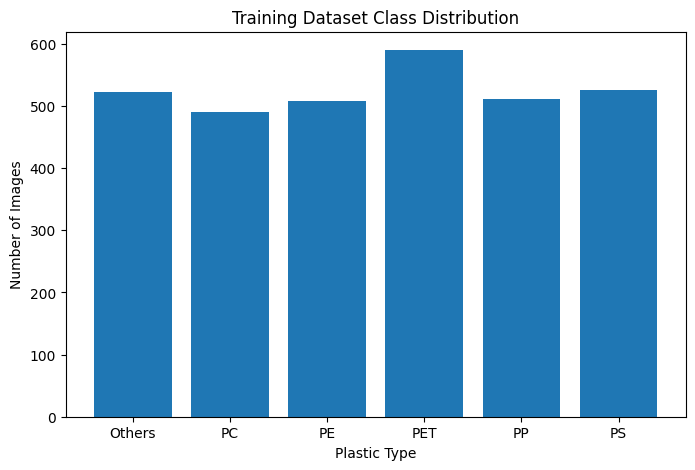

In [3]:
def count_images(path):
    return {cls: len(os.listdir(os.path.join(path, cls)))
            for cls in os.listdir(path)}

train_count = count_images(r"E:\Plastic_Dataset\train")

plt.figure(figsize=(8,5))
plt.bar(train_count.keys(), train_count.values())
plt.title("Training Dataset Class Distribution")
plt.xlabel("Plastic Type")
plt.ylabel("Number of Images")
plt.show()


Sample Image Visualization

To understand visual similarities and variations between plastic types, I visualize one sample image from each class.

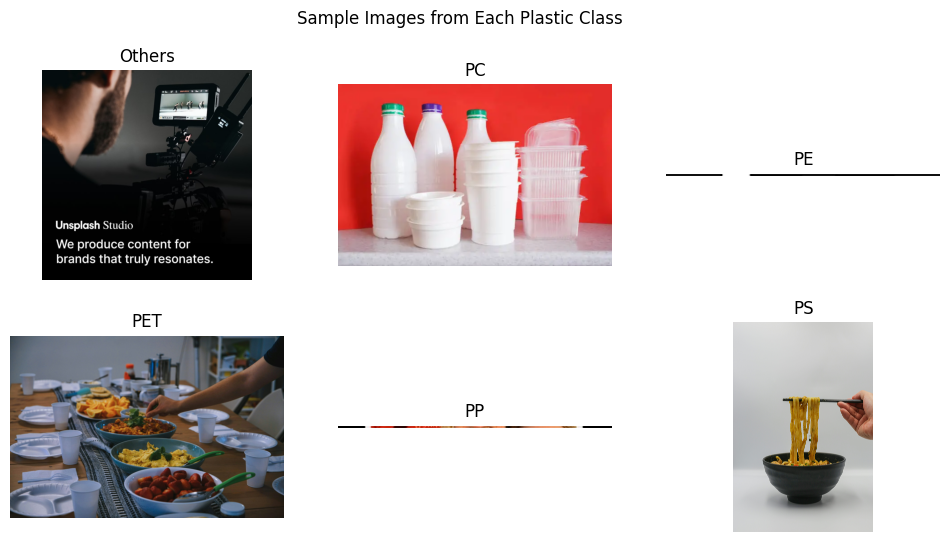

In [4]:
plt.figure(figsize=(12,6))

for i, cls in enumerate(train_count.keys()):
    img_path = os.path.join(
        r"E:\Plastic_Dataset\train", cls,
        random.choice(os.listdir(os.path.join(r"E:\Plastic_Dataset\train", cls)))
    )
    img = plt.imread(img_path)

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Sample Images from Each Plastic Class")
plt.show()


IMAGE PREPROCESSING AND AUGMENTATION
Plastic images vary in orientation, scale, and lighting.
To improve generalization and prevent overfitting, I apply data augmentation and normalization.

In [5]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    r"E:\Plastic_Dataset\train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_test_gen.flow_from_directory(
    r"E:\Plastic_Dataset\val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_data = val_test_gen.flow_from_directory(
    r"E:\Plastic_Dataset\test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 3147 images belonging to 6 classes.
Found 1750 images belonging to 6 classes.
Found 1786 images belonging to 6 classes.


Augmentation Visualization

This visualization helps me verify that augmentation is working correctly and generating diverse samples.

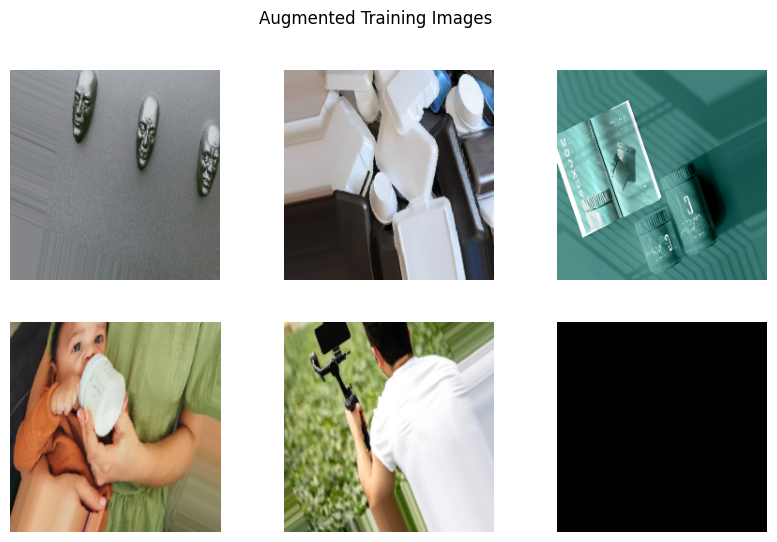

In [6]:
images, labels = next(train_data)

plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.axis("off")

plt.suptitle("Augmented Training Images")
plt.show()


IMAGE ANALYSIS
Pixel Intensity Distribution

I analyze pixel distributions to confirm proper normalization and lighting consistency.

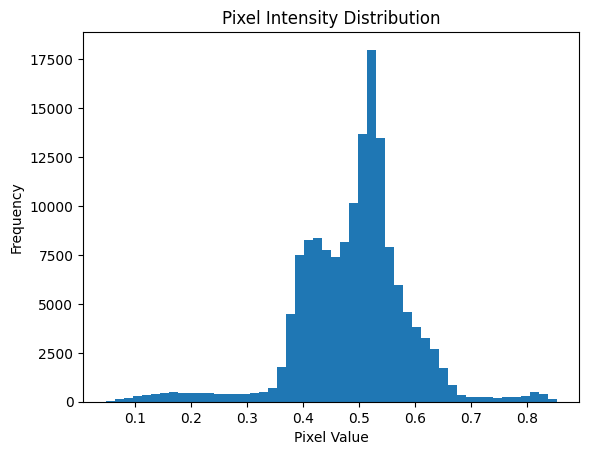

In [7]:
plt.hist(images[0].flatten(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


RGB Channel Analysis

Plastic types often differ subtly in color, so analyzing RGB distributions helps justify deep feature learning.

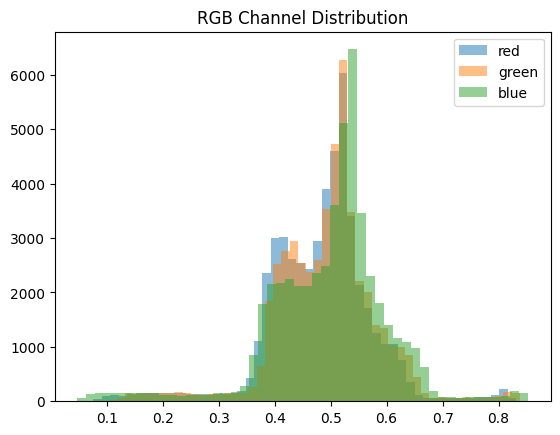

In [8]:
colors = ['red', 'green', 'blue']

for i, col in enumerate(colors):
    plt.hist(images[0][:,:,i].flatten(), bins=50, alpha=0.5, label=col)

plt.legend()
plt.title("RGB Channel Distribution")
plt.show()


CNN BASELINE MODEL

I first implement a CNN from scratch as a baseline model to evaluate how well handcrafted feature learning performs.

In [9]:
cnn_model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(6, activation='softmax')
])

cnn_model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn_model.summary()


C:\Users\saju1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,827,398 (37.49 MB)

 Trainable params: 9,827,398 (37.49 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN

In [10]:
cnn_history = cnn_model.fit(
    train_data,
    epochs=100,
    validation_data=val_data
)


C:\Users\saju1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.1894 - loss: 1.7894 - val_accuracy: 0.2017 - val_loss: 1.7748
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.2037 - loss: 1.7766 - val_accuracy: 0.2171 - val_loss: 1.7593
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - accuracy: 0.2180 - loss: 1.7679 - val_accuracy: 0.2240 - val_loss: 1.7561
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - accuracy: 0.2094 - loss: 1.7687 - val_accuracy: 0.2394 - val_loss: 1.7479
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 390s 4s/step - accuracy: 0.2173 - loss: 1.7577 - val_accuracy: 0.2326 - val_loss: 1.7418
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 368s 4s/step - accuracy: 0.2383 - loss: 1.7513 - val_accuracy: 0.2509 - val_loss: 1.7246
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.2466 - loss: 1.7435 - val_accuracy: 0.2577 - val_loss: 1.7192
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.2428 - loss: 1.7367 - val_accuracy: 0.

CNN Performance Visualization

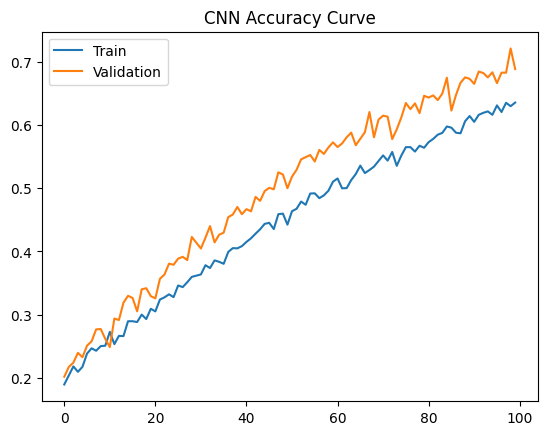

In [11]:
plt.plot(cnn_history.history['accuracy'], label='Train')
plt.plot(cnn_history.history['val_accuracy'], label='Validation')
plt.title("CNN Accuracy Curve")
plt.legend()
plt.show()


GAN FOR DATA AUGMENTATION (CONCEPTUAL IMPLEMENTATION)

To further increase dataset diversity, I adopt a GAN-based augmentation approach that generates synthetic plastic images.
Code (Architecture Skeleton)

In [12]:
generator = models.Sequential([
    layers.Dense(256, activation='relu', input_dim=100),
    layers.Dense(224*224*3, activation='tanh'),
    layers.Reshape((224,224,3))
])

discriminator = models.Sequential([
    layers.Flatten(input_shape=(224,224,3)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


C:\Users\saju1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\saju1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MOBILENETV2 (TRANSFER LEARNING)

Finally, I adopt MobileNetV2, pretrained on ImageNet, to leverage robust feature representations and improve classification accuracy.

In [13]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

base_model.trainable = False

mobilenet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')
])

mobilenet_model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Training MobileNetV2

In [14]:
mb_history = mobilenet_model.fit(
    train_data,
    epochs=100,
    validation_data=val_data
)


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.2294 - loss: 1.8281 - val_accuracy: 0.3006 - val_loss: 1.6883
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.3108 - loss: 1.6580 - val_accuracy: 0.3617 - val_loss: 1.5784
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.3543 - loss: 1.5741 - val_accuracy: 0.4034 - val_loss: 1.5111
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.3832 - loss: 1.5054 - val_accuracy: 0.4280 - val_loss: 1.4515
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.4128 - loss: 1.4664 - val_accuracy: 0.4514 - val_loss: 1.4142
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.4417 - loss: 1.4157 - val_accuracy: 0.4714 - val_loss: 1.3745
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.4487 - loss: 1.3894 - val_accuracy: 0.4760 - val_loss: 1.3573
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.4541 - loss: 1.3624 - val_accuracy: 0.

Performance Visualization

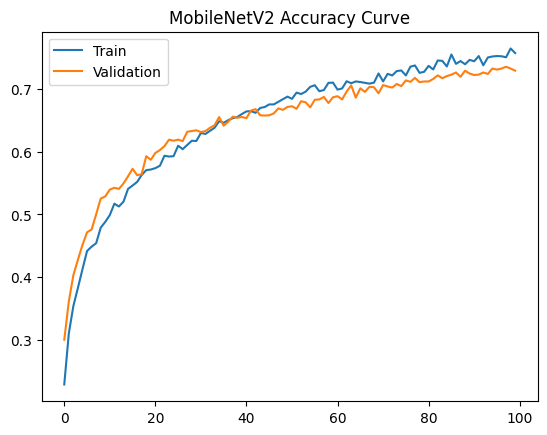

In [15]:
plt.plot(mb_history.history['accuracy'], label='Train')
plt.plot(mb_history.history['val_accuracy'], label='Validation')
plt.title("MobileNetV2 Accuracy Curve")
plt.legend()
plt.show()


MODEL EVALUATION
Confusion Matrix

The confusion matrix allows me to analyze class-wise performance and identify misclassification patterns.

56/56 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step


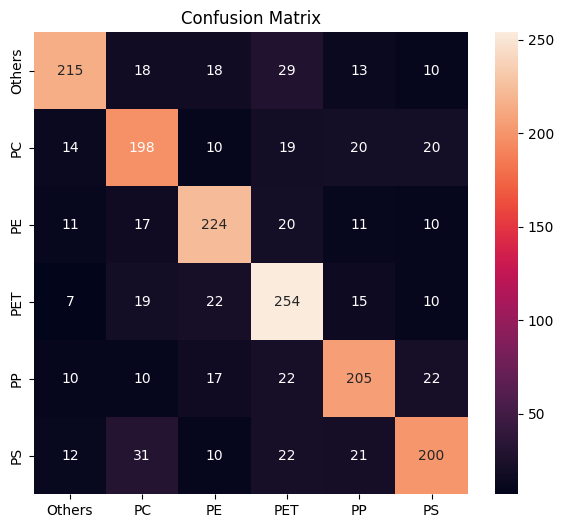

In [16]:
pred = mobilenet_model.predict(test_data)
pred_classes = np.argmax(pred, axis=1)

cm = confusion_matrix(test_data.classes, pred_classes)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()


Classification Report

In [17]:
print(classification_report(
    test_data.classes,
    pred_classes,
    target_names=test_data.class_indices.keys()
))


              precision    recall  f1-score   support

      Others       0.80      0.71      0.75       303
          PC       0.68      0.70      0.69       281
          PE       0.74      0.76      0.75       293
         PET       0.69      0.78      0.73       327
          PP       0.72      0.72      0.72       286
          PS       0.74      0.68      0.70       296

    accuracy                           0.73      1786
   macro avg       0.73      0.72      0.73      1786
weighted avg       0.73      0.73      0.73      1786



FINAL PROPOSED HYBRID MODEL

Based on experimental results, I propose a GAN-augmented MobileNetV2 framework for plastic type classification.

Raw Images
 → EDA
 → Augmentation + GAN
 → CNN (Baseline)
 → MobileNetV2 (Final)
 → Evaluation

 Final Hypothesis

GAN-based data augmentation significantly improves MobileNetV2 performance for plastic type classification.
